# Pets dataset with single-label and multi-label classification

**Objective:** In this notebook, I want to compare the single-label and multi-label classification approaches for the [PETS dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). This dataset has 37 categories of cats and dogs and the idea is that we want to classify an input image into 0 or 1 or more than 1 of these 37 categories. 

With single-label classification, an input image will by design be classified into exactly ONE of these 37 categories (even if the input image does not contain a cat or a dog from the 37 categories). With multi-label classification, it should theoretically be possible to tell whether the input image has 0 or 1 or more than 1 of these 37 categories. In particular, we want to see if multi-label classification approaches can reliably tell us in if an input image belongs to NONE of the classes seen during training. Along the way, I also want to compare and contrast the results from single- and multi-label classification as well as the functions used to calculate the loss and accuracy. 

As before, the reference for everything in this blog post is the [fastai 2020 course](https://course.fast.ai), especially the [amazing textbook](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527). In addition, for this notebook, for multi-label classification, I am repeating the results from the following notebooks (albeit with minor changes to align it closer to the textbook material): [1](https://forums.fast.ai/t/how-to-use-bcewithlogitslossflat-in-lesson1-pets-ipynb/59146) and [2](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/03_Unknown_Labels.ipynb) (Thanks to @muellerzr).

### Intuition and code for key differences between single- and multi-label classification

Note that the big changes between the two classification models is that they use different loss functions and accuracy functions.

- single-label classification uses cross-entropy loss (negative log-likelihood of softmax) as the loss function. And an accuracy function that will pick ONE index (out of N indices) corresponding to the max. activation from the final layer as the prediction
- multi-label classification uses binary cross-entropy loss (with a sigmoid of activations from the final layer and *One-Hot Encoding* of the targets/training labels) as the loss function. And an accuracy function that will use a threshold to determine which activations out of N activations are 1. The indices corresponding to the activations that are 1 are the predictions. Note that none of the N activations can be higher than the threshold (input image is "none-of-the-above", or more than 1 of the activations can be higher than the threshold (input image has more than 1 category of object inside) or exactly 1 of the activations can be higher than the threshold (input image has 1 category of object inside).

For single-label classification, the loss function used is the cross-entropy loss. It is defined as follows:

    def cross_entropy_loss(acts, tgts):
        '''
        The line below does two things:
        1. It first spreads the activations from 0 to 1 using the softmax function. 
        The softmax function = e^x/sum(e^x) and this function amplifies differences 
        between the activations so that ONE activation can stand out as the correct 
        answer AND the sum of all activations post the softmax is equal to 1.
        2. it further spreads the softmax-ed activations between 0 and 1 to be between
        -inf and +inf by taking the log
        '''
        log_softmax_acts = torch.log_softmax(acts, dim=1) 
        
        '''
        The line below is a fancy way of saying that the log_softmax(activation) value 
        corresponding to the correct target/label index is the loss that needs to be 
        minimized by SGD
        '''
        return F.nll_loss(log_softmax_acts, tgts)

For single-label classification, the accuracy function used is:
  
    def accuracy(acts, tgts, axis=-1):
        '''
        The line below basically selects the indices corresponding to the max. activation 
        values for the input images being classified. The indices should match the target/labels.
        '''
        pred = acts.argmax(dim=axis) 
        
        '''
        The line below calculates how many of the predicted indices match the 
        target/labels and calculates the mean. Note that for each image, there is only ONE correct 
        matching label here.
        '''
        return (pred == tgts).float().mean()
    

For multi-label classification, the loss function is very different. The accuracy function is also slightly different but we will start with explaining the loss function. To do so, let us first look at how the data is encoded for multi-label classification. 

For multi-label classification, the target labels are encoded using *One-Hot Encoding*. What this means is that if there are 37 pet breeds, then for each image, the label/dependent variable will be of the form:
    
    y = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0] # len(y) = 37
    
Basically, with a one-hot encoded target, there will be a 0 for each class or label that is not present and a 1 for each class of label that is present in the input image. This is to support the case where there are input images with more than ONE label or the case where there are input images with no labels. Here, for the [PETS dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), we will have only 1 label per image but we want to see if the multi-class model when trained as such can detect images with no known/previously-seen PET labels. This is a good way to represent data for classification with more than 1 label or with no labels as PyTorch (and the GPU underneath) needs/works better with tensors where everything has the same dimensions (we cannot have y for different images with different lengths).

Note that *One-Hot Encoding* does not change the dimensions of the activations from the final layer when compared to a single-label classification model. Even with multi-label classification, for each input image, the activations from the final layer will be a vector of length N (for N classes). However, the interpretation of these N activations from the final layer are different when it comes to calculating the loss and the accuracy. 

For loss calculations, we use the binary cross-entropy loss function as defined below:

    def binary_cross_entropy_loss(acts, tgts):
        '''
        The line below basically spreads the activations from 0 to 1 using the sigmoid function
        '''
        sigmoid_acts = acts.sigmoid()
        
        '''
        The intuition for the line below is as follows:
        - if target is 1, we want activations to be closer to 1 and if the target is 0, 
        we want the activations to be closer to 0. 
        - the torch.where function will measure how distant each prediction is from 1 if it should be 1 
        and how distant it is from 0 if it should be 0. 
        - -log(sigmoid(acts)) is the loss. -log(x) reaches Infinity when x reaches 0 and 
        reaches 0 when x reaches 1. So, if sigmoid(acts) is closer to 1 where it should be 1,  
        -log(sigmoid(acts)) will be closer to 0, i.e. the loss will be low. If -log(sigmoid(acts)) 
        in this case is not closer to 1, then -log(sigmoid(acts)) will correspondingly be closer 
        to Infinity, i.e. loss will be high.
        - Similarly, for the case when the activations should be 0, if sigmoid(acts) is closer 
        to 0, 1-sigmoid_acts will be closer to 1. In this case, then -log(sigmoid(acts)) will be 
        closer to 0, i.e. low loss. And the high loss case will play out in reverse as explained for the 
        case above.
        
        Note that there is a loss value per category that is getting optimized separately without the 
        need to emphasize/select one category over others. The sum of the activations post the sigmoid 
        need not add up to 1 and can add up to more than 1 or even less than 1. The key thing that matters is 
        whether the individual activation values, post the sigmoid are closer to 0 or closer to 1.
        '''
        return -torch.where(tgts==1, sigmoid_acts, 1-sigmoid_acts).log().mean()        

Since we can have more than one prediction per image, the accuracy function is also different from that used for single-label classification. As discussed earlier as part of the loss function definition, there are N activations 
per image and we need to know if each activation, post the sigmoid function, is closer to a 0 or a 1. We do this 
by picking a threshold and everything above the threshold is a 1 and everything below is considered a 0.

    def accuracy_multi(acts, tgts, thresh=0.5, sigmoid=True):
        if sigmoid: acts = acts.sigmoid()
        return ((acts>thresh)==tgts.bool()).float().mean()

With that information digested, let us now get into the code to train single- and multi-label classification models for the [PETS dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) and run some inferences to see how they behave.

### Get the basic imports out of the way

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *

In [ ]:
from fastai.vision.all import *

### Get the dataset and the dataloaders ready

In [4]:
path = untar_data(URLs.PETS)

In [5]:
path.ls()

(#3) [Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/models'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/annotations')]

In [6]:
(path/'images').ls()

(#7394) [Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/english_setter_58.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/newfoundland_77.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/american_bulldog_168.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Bengal_76.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Abyssinian_196.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Bengal_123.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/leonberger_179.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_116.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/pug_33.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/scottish_terrier_155.jpg')...]

In this dataset, the labels are provided as part of the filename of the input images. We need regex to extract the label that corresponds to each image.

In [7]:
fname = (path/'images').ls()[0]

In [8]:
fname

Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/english_setter_58.jpg')

In [22]:
str(fname)

'/home/igolgi/.fastai/data/oxford-iiit-pet/images/english_setter_58.jpg'

In [10]:
pat = re.findall(r'(.+)_\d+.jpg$', fname.name); pat

['english_setter']

In [12]:
doc(RegexLabeller)

In [13]:
doc(using_attr)

In [14]:
fname.name

'english_setter_58.jpg'

In [15]:
fname.absolute

<bound method Path.absolute of Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/english_setter_58.jpg')>

In [16]:
fname.parent

Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images')

In [24]:
pat_multi = re.findall(r'/([^/]+)_\d+.jpg$', str(fname)); pat_multi

['english_setter']

In [25]:
doc(Pipeline)

### Using fastai's DataBlock API to get the data ready for training

We can use fastai's DataBlock API to do the following:
- read in the images and convert them to tensors
- split up the data into training and validation data to be used during training. Here, we do a random split of 80% training and 20% validation from the dataset provided (~200 images per category for 37 categories of dogs and cats)
- extract the label automatically from each input filename and populate the corresponding dependent variable/labely tensor
- perform data augmentation during training that will maximize our accuracy based on heuristic approaches that work reliably in practice. In particular, we perform the following augmentations:
  - each image is resized to 460x460 pixels as part of a fastai-recommended strategy called [Presizing](https://medium.com/unpackai/preseizing-techniques-for-image-classification-using-fastai-660a493cfc96) that increases the input image size before additional transforms are carried out so as to minimize warping and other artifacts that can arise out of transforms carried out during augmentation. In addition, we take a random crop of this resized input image as our training data. This is what `RandomResizedCrop` does as part of `item_tfms`.
  - each batch of images is resized to 224x224 pixels and we normalize the images so that they have a mean of 0 and std. dev. of 1 to match what was used for the pre-trained Imagenet model. Note that the resizing to 224x224 pixels is to make sure all images passing through the GPU are the same size. The normalization will result in higher training accuracy and more stability during training while keeping the same image stats that were used on the pre-trained model that is the starting point there. In addition, the fastai library will perform a standard set of transforms (rotate, flip, perspective warping, brightness changes and contrast changes) as part of `aug_transforms` that have been found to work well in practice. Note that `aug_transforms` and `normalize` are called on an entire batch of images on the GPU and hence are very fast.

In [29]:
pat = r'(.+)_\d+.jpg$'
label_func = using_attr(RegexLabeller(pat), 'name')
pets_single = DataBlock(blocks = (ImageBlock, CategoryBlock),
                        get_items = get_image_files,
                        splitter=RandomSplitter(valid_pct=0.2, seed=42),
                        get_y=label_func,
                        item_tfms=RandomResizedCrop(460, min_scale=0.75),
                        batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [30]:
pets_multi = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                       get_items = get_image_files,
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       get_y=Pipeline([label_func, lambda label: [label]]),
                       item_tfms=RandomResizedCrop(460, min_scale=0.75),
                       batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [33]:
dls_single = pets_single.dataloaders(path/"images", bs=32)

In [34]:
dls_multi = pets_multi.dataloaders(path/"images", bs=32)

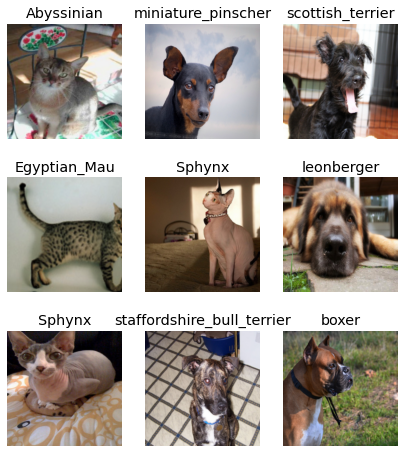

In [35]:
dls_single.show_batch(max_n=9, figsize=(7,8))

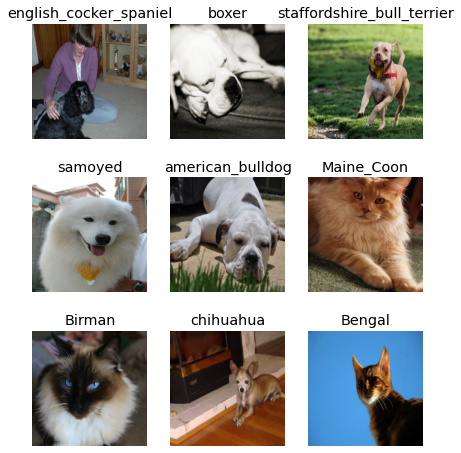

In [36]:
dls_multi.show_batch(max_n=9, figsize=(7,8))

### Train and evaluate the single-label classification model first

We will instantiate an object of the cnn_learner class that uses a resnet34 backbone. Under the hood, fastai will infer from the dataloader (and how its setup inside) that we need to use `nn.CrossEntropyLoss` for single-label classification here.

In [38]:
learn_single = cnn_learner(dls_single, resnet34, pretrained=True, metrics=accuracy)

What learning rate should we use?

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.00363078061491251)

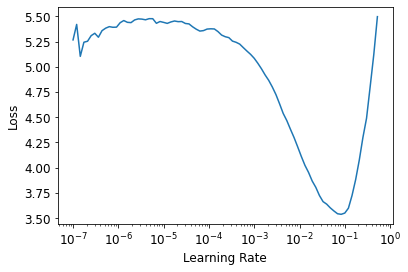

In [40]:
learn_single.lr_find()

We will stick to the default learning rate of 2e-3 as it should work just fine here. Note that we are not (yet) aiming to create the best model for single-label classification so here, we are just trying to get A decent model first and build intuition.

Also note that the `fine_tune` function will do the following:
- it first freezes all layers other than the last layer that was added for this dataset and train for 1 epoch
- it will then unfreeze all the layers and then train for additional epochs
- it uses [`fit_one_cycle`](https://arxiv.org/pdf/1803.09820.pdf) underneath that uses cyclical learning rates to better handle the crests and troughs of the loss rate function curve

In [41]:
learn_single.fine_tune(4, base_lr=2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.008489,0.358443,0.876184,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.514506,0.399833,0.880920,00:39
1,0.440027,0.321655,0.903248,00:40
2,0.251060,0.228398,0.923545,00:40
3,0.115164,0.199281,0.930311,00:40


In [42]:
learn_single.save("pets-single-best-resnet34")

Path('models/pets-single-best-resnet34.pth')

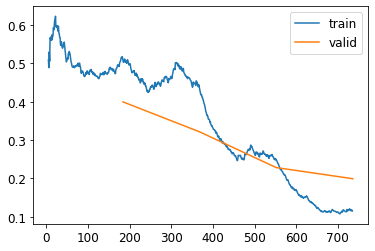

In [43]:
learn_single.recorder.plot_loss()

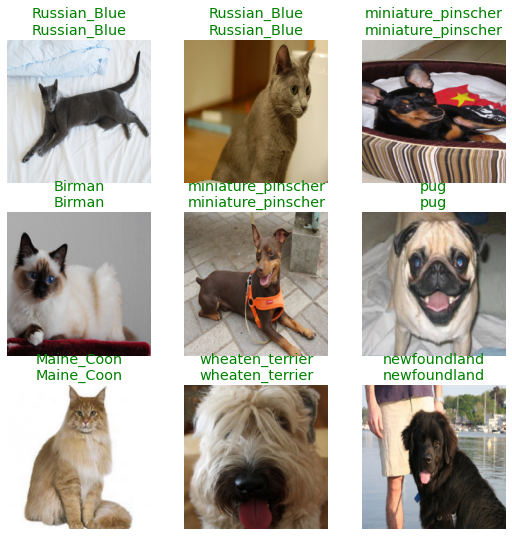

In [44]:
learn_single.show_results()

### Let's see how the single-label classification model does on test images (from the Internet)

<AxesSubplot:>

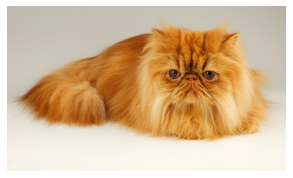

In [48]:
img = PILImage.create('persian_cat.jpg')
img.show()

In [49]:
learn_single.predict(img)

('Persian',
 tensor(7),
 tensor([8.6543e-08, 5.4637e-08, 4.0302e-06, 4.8134e-08, 1.6625e-06, 1.1779e-08, 8.0148e-06, 9.9998e-01, 8.9213e-07, 1.2397e-10, 3.1862e-10, 3.0510e-08, 1.4689e-09, 3.4483e-10, 5.5071e-08, 5.3021e-10,
         1.2125e-08, 9.0605e-10, 4.4580e-09, 8.4903e-10, 2.9560e-09, 4.4305e-09, 6.9695e-08, 4.4511e-06, 4.9368e-09, 1.3574e-08, 2.7102e-09, 6.5724e-07, 9.9739e-07, 1.0707e-07, 1.3508e-07, 1.1465e-08,
         2.4983e-09, 5.1974e-09, 2.3698e-10, 1.1149e-08, 2.4109e-07]))

Gets the right answer for a persian cat image from the Internet. Not bad. How about an image from a category its not seen before? Let's try a donkey image.

<AxesSubplot:>

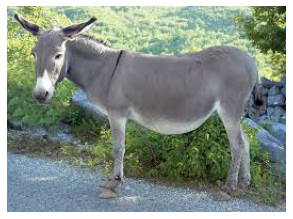

In [51]:
img = PILImage.create('donkey.jpg')
img.show()

In [52]:
learn_single.predict(img)

('american_pit_bull_terrier',
 tensor(13),
 tensor([6.8285e-03, 2.6866e-04, 2.4101e-04, 2.0642e-04, 3.9007e-04, 4.6434e-03, 2.0361e-04, 2.9735e-05, 2.3561e-04, 7.4638e-02, 2.1234e-03, 2.9009e-02, 5.6169e-03, 4.2922e-01, 1.6631e-03, 9.5369e-03,
         1.8752e-02, 4.2473e-03, 2.3025e-04, 1.1018e-02, 2.5009e-02, 4.0329e-03, 4.3327e-05, 2.0865e-04, 1.8217e-02, 2.1598e-04, 3.3468e-01, 1.9827e-04, 7.4498e-05, 2.1756e-03, 4.7525e-05, 3.9339e-03,
         1.0191e-03, 6.1575e-03, 4.6382e-03, 1.6563e-04, 7.9941e-05]))

Calls it an "american_pit_bull_terrier". Not right.

### Let's train the multi-label classifier now

Key things to note here:

- The accuracy function used will use a high threshold of 0.95 so that only results the model is very confident about will be selected when reporting the accuracy during training. For the loss function, we use the binary_cross_entropy loss function as specified in the [textbook](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527). Note that the flattened version of `nn.BCEWithLogitsLoss` can also be used to get the same results as shown in this [reference notebook](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/03_Unknown_Labels.ipynb).
- the same resnet34 backbone is used and fastai will automatically infer the loss function to use based on how the dataloader is setup
- `partial` is a cool python trick to fix/specify a particular argument value for an existing function

In [57]:
learn_multi = cnn_learner(dls_multi, resnet34, pretrained=True, metrics=[partial(accuracy_multi, thresh=0.95)])

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.03981071710586548)

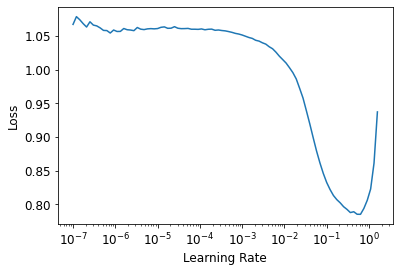

In [58]:
learn_multi.lr_find()

In [59]:
learn_multi.fine_tune(epochs=4, base_lr=2e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.413710,0.065867,0.973741,00:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.053688,0.023568,0.981970,00:40
1,0.027428,0.014555,0.989431,00:40
2,0.015373,0.010602,0.991790,00:40
3,0.010254,0.009575,0.992576,00:40


In [60]:
learn_multi.save("pets-multi-best-resnet34")

Path('models/pets-multi-best-resnet34.pth')

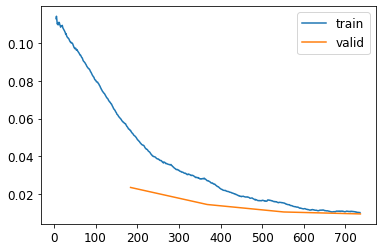

In [61]:
learn_multi.recorder.plot_loss()

Wow! That looks great and also the accuracy is better than that for the single-label classification model. Do not know why yet.

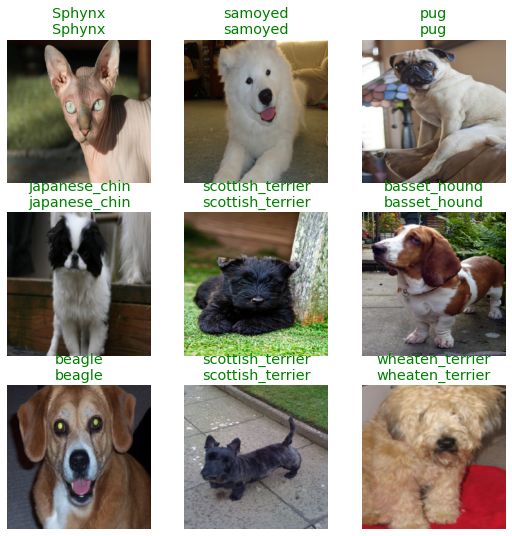

In [62]:
learn_multi.show_results()

### Let's see how the multi-label classification model does on test images (from the Internet)

<AxesSubplot:>

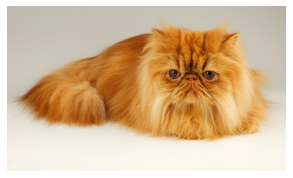

In [64]:
img = PILImage.create("persian_cat.jpg"); 
img.show()

In [65]:
learn_multi.predict(img)

((#1) ['Persian'],
 tensor([False, False, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]),
 tensor([1.3112e-04, 3.7481e-04, 9.7096e-04, 7.3606e-05, 2.6053e-04, 1.2581e-04, 1.1585e-03, 9.9327e-01, 1.4942e-04, 2.8816e-05, 1.7016e-04, 2.6868e-04, 3.1796e-04, 7.9010e-04, 1.3533e-04, 4.2544e-04,
         4.4185e-04, 3.6798e-05, 2.6048e-04, 5.3761e-05, 1.7554e-04, 3.8640e-04, 2.1269e-04, 1.7576e-03, 6.0463e-05, 3.0593e-04, 3.0365e-04, 4.0525e-04, 4.3490e-04, 3.1499e-04, 3.1902e-04, 7.0238e-04,
         1.4212e-04, 1.6981e-04, 1.0651e-04, 1.8955e-04, 3.7189e-04]))

Correct prediction!

<AxesSubplot:>

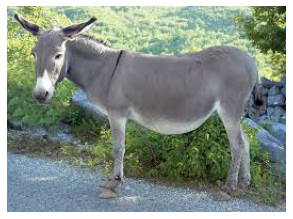

In [66]:
img = PILImage.create("donkey.jpg"); 
img.show()

In [67]:
learn_multi.predict(img)

((#0) [],
 tensor([False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]),
 tensor([0.0019, 0.0005, 0.0006, 0.0005, 0.0004, 0.0041, 0.0003, 0.0014, 0.0008, 0.0292, 0.0006, 0.0223, 0.0006, 0.0495, 0.0058, 0.0098, 0.0166, 0.0017, 0.0004, 0.0064, 0.0037, 0.0016, 0.0004, 0.0004,
         0.0018, 0.0012, 0.1673, 0.0016, 0.0004, 0.0005, 0.0006, 0.0016, 0.0049, 0.0053, 0.0014, 0.0003, 0.0003]))

<AxesSubplot:>

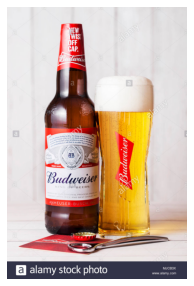

In [68]:
img = PILImage.create('beer-pic.jpg')
img.show()

In [69]:
learn_multi.predict(img)

((#0) [],
 tensor([False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]),
 tensor([0.0024, 0.0038, 0.0024, 0.0067, 0.0460, 0.0029, 0.0048, 0.0012, 0.0076, 0.0052, 0.0012, 0.0012, 0.0032, 0.0088, 0.0155, 0.0023, 0.0177, 0.0027, 0.0021, 0.0058, 0.0054, 0.0022, 0.0095, 0.0013,
         0.0015, 0.0059, 0.0126, 0.0102, 0.0043, 0.0064, 0.0194, 0.0045, 0.0395, 0.0198, 0.0018, 0.0025, 0.0063]))

Superb! No prediction for "false" images crossed a threshold of even 0.5. If you look at the activations, all values are low! This is what we want. We did not do anything special other than use a multi-label classifier with the right loss function. 

### Can we get similar results at "none of the above" detection with a smaller number of categories?

We are not getting similar great results with my bears dataset compiled from the Internet. Perhaps the difference comes from the differences in the datasets? There are two basic differences:

- lower number of categories: the bears dataset has three categories of bears ("grizzly", "black", and "teddy") compared to 37 categories of pets here. 
- lower image count per category: the pets dataset has ~200 images/class while my bears dataset after the last curation has ~100+ images for grizzly and black bears and ~50+ images for teddy bears.

I want to explore these differences one at a time, starting with lower number of categories. I filter the dataset here so that we use data only from three categories to match the bears dataset.

In [72]:
len(dls_multi.train_ds), len(dls_multi.valid_ds)

(5912, 1478)

In [100]:
fns = get_image_files(path/'images'); fns

(#7390) [Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/english_setter_58.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/newfoundland_77.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/american_bulldog_168.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Bengal_76.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Abyssinian_196.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Bengal_123.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/leonberger_179.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_116.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/pug_33.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/scottish_terrier_155.jpg')...]

In [101]:
fns[0].name

'english_setter_58.jpg'

#### We are just going to focus on the three classes, Bengal (cat), newfoundland and Wheaten Terrier (dogs) now

In [108]:
three_class_info = L([item for item in fns if "Bengal" in item.name or "wheaten_terrier" in item.name or "newfoundland" in item.name])

In [109]:
three_class_info

(#600) [Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/newfoundland_77.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Bengal_76.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Bengal_123.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/newfoundland_73.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_126.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_98.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/newfoundland_135.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Bengal_4.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/newfoundland_178.jpg'),Path('/home/igolgi/.fastai/data/oxford-iiit-pet/images/Bengal_25.jpg')...]

In [110]:
len(set(three_class_info))

600

In [112]:
# set(three_class_info)

In [113]:
doc(get_image_files)

In [114]:
def get_three_class_images(path, recurse=True, folders = None):
    fns = get_image_files(path)
    three_class_info = L([item for item in fns if "Bengal" in item.name or "wheaten_terrier" in item.name or "newfoundland" in item.name])
    return three_class_info

#### Lets redefine the dataloader using the DataBlock API. 

The only change from earlier is that we use my `get_three_class_images` function defined above instead of the standard `get_image_files` function.

In [115]:
three_class_pets_multi = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                                   get_items = get_three_class_images,
                                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                                   get_y=Pipeline([label_func, lambda label: [label]]),
                                   item_tfms=RandomResizedCrop(460, min_scale=0.75),
                                   batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [116]:
three_class_dls_multi = three_class_pets_multi.dataloaders(path/"images", bs=32)

In [118]:
len(three_class_dls_multi.train_ds), len(three_class_dls_multi.valid_ds)

(480, 120)

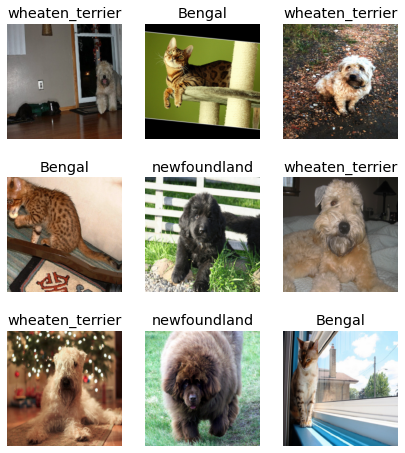

In [119]:
three_class_dls_multi.show_batch(max_n=9, figsize=(7,8))

#### Let's train the multi-label classifier using the same resnet34 backbone on data from just the 3 classes of Pets

In [120]:
three_class_learn_multi = cnn_learner(three_class_dls_multi, resnet34, pretrained=True, metrics=[partial(accuracy_multi, thresh=0.95)])

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0014454397605732083)

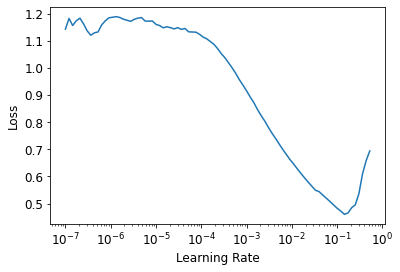

In [121]:
three_class_learn_multi.lr_find()

In [122]:
x,y = three_class_dls_multi.one_batch()

In [124]:
x.shape,y.shape

((32, 3, 224, 224), (32, 3))

In [125]:
y[0]

TensorMultiCategory([1., 0., 0.], device='cuda:0')

In [126]:
three_class_learn_multi.fine_tune(epochs=3, base_lr=2e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.526490,0.033094,0.997222,00:03


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.057233,0.014944,1.000000,00:04
1,0.034515,0.004499,1.000000,00:04
2,0.024078,0.004110,1.000000,00:04


In [127]:
three_class_learn_multi.save("three-class-multi-pets-best-resnet34")

Path('models/three-class-multi-pets-best-resnet34.pth')

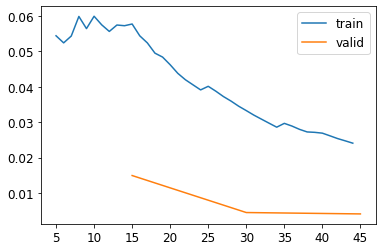

In [128]:
three_class_learn_multi.recorder.plot_loss()

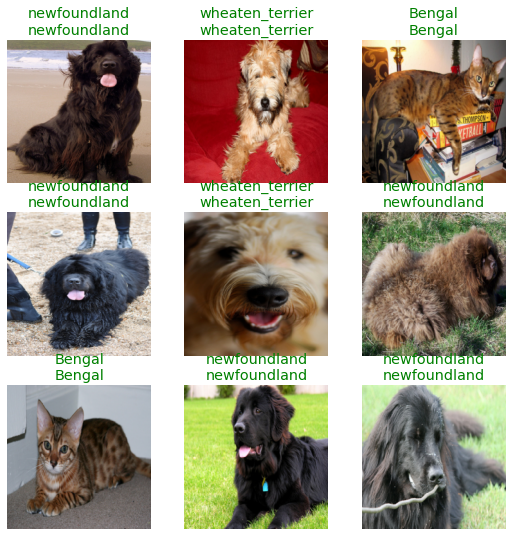

In [129]:
three_class_learn_multi.show_results()

#### Let's see how this 3-class multi-label classification model does on test images (from the Internet)

<AxesSubplot:>

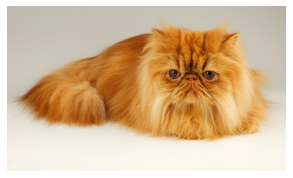

In [130]:
img = PILImage.create("persian_cat.jpg"); 
img.show()

In [131]:
three_class_learn_multi.predict(img)

((#2) ['Bengal','newfoundland'],
 tensor([ True,  True, False]),
 tensor([0.9268, 0.5962, 0.0277]))

Prediction is Bengal with a confidence of 92.68%. Not bad that it managed to match it to the Cat in the 3 categories. If we want to filter this, our threshold of 0.95 will filter it out if needed. The `learn.predict` function will report anything above a threshold of 0.5.

<AxesSubplot:>

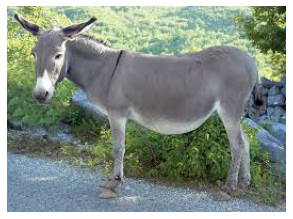

In [136]:
img = PILImage.create("donkey.jpg"); 
img.show()

In [137]:
three_class_learn_multi.predict(img)

((#1) ['Bengal'],
 tensor([ True, False, False]),
 tensor([0.7182, 0.0139, 0.0584]))

This model calls it a Bengal but with a low confidence of 71%. We can filter this out using a high threshold. But do note the difference in results from the case where we used 37 categories of data to train the multi-class model. With that model, this donkey image was fully rejected with much lower confidence/activation values. Something to think about.

<AxesSubplot:>

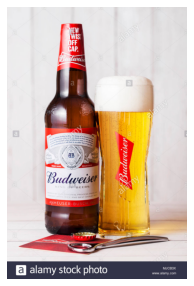

In [138]:
img = PILImage.create("beer-pic.jpg"); 
img.show()

In [139]:
three_class_learn_multi.predict(img)

((#0) [], tensor([False, False, False]), tensor([0.1369, 0.1342, 0.1894]))

OK, good to see an empty prediction as none of the confidences are higher than 0.5. This image will be classified as "none-of-the-above" without setting a very high threshold.

One more test with a grizzly bear image and we see this image is also rejected or classified as "none-of-the-above". 

<AxesSubplot:>

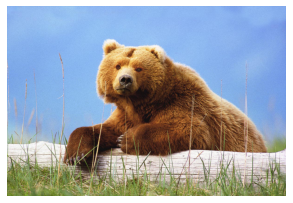

In [140]:
img = PILImage.create('Grizzly-on-log.jpg')
img.show()

In [141]:
three_class_learn_multi.predict(img)

((#0) [], tensor([False, False, False]), tensor([0.0130, 0.2415, 0.4333]))

#### Conclusions:

- Multi-label classifiers can reject input images that don't belong to any of the trained categories/classes
- It looks like we do need to have "enough" training data for multi-label classifiers to work well. Specifically, "enough" training data can mean that we need both training data for many categories (>3?) and ~200 training images per category. The exact limits need to be investigated further. 
- Relating to the poorer results on my bears dataset, the PETS dataset has 200 images per class. Perhaps we need to increase the number of valid images in our bears dataset for the 3 categories in order to filter out the false positives and provide more confidence to the model? 